Ref:
https://www.evanmarie.com/finance-stocks/

# Data preparation

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the precision to 5 decimal places
pd.set_option('display.precision', 5)

# Set the precision to 5 decimal places for numpy
np.set_printoptions(precision=5)

# Define the stock symbols for different sectors
stock_symbols = ['MSFT', 'JNJ', 'JPM', 'DIS', 'BA', 'CVX']

# Define the date range
start_date = '2013-01-01'
end_date = '2024-01-01'

# Download data for each stock symbol
# We will store the adjusted close prices in a DataFrame
prices = pd.DataFrame()

for symbol in stock_symbols:
    ticker = yf.Ticker(symbol)
    hist_data = ticker.history(start=start_date, end=end_date)
    # Extracting adjusted close prices and renaming the column to the stock symbol
    prices[symbol] = hist_data['Close'].rename(symbol)

# Handling missing values by interpolation
prices.interpolate(method='linear', inplace=True)
prices.head()


,MSFT,JNJ,JPM,DIS,BA,CVX
Date,,,,,,
2013-01-02 00:00:00-05:00,22.53285,51.97496,32.69142,46.30373,64.58387,69.48188
2013-01-03 00:00:00-05:00,22.23100,51.90159,32.62552,46.40342,64.91908,69.18608
2013-01-04 00:00:00-05:00,21.81493,52.49588,33.20383,47.29142,65.10340,69.55115
2013-01-07 00:00:00-05:00,21.77414,52.38583,33.24041,46.18595,63.79613,69.07906
2013-01-08 00:00:00-05:00,21.65993,52.39317,33.30631,45.99565,62.12014,68.77064


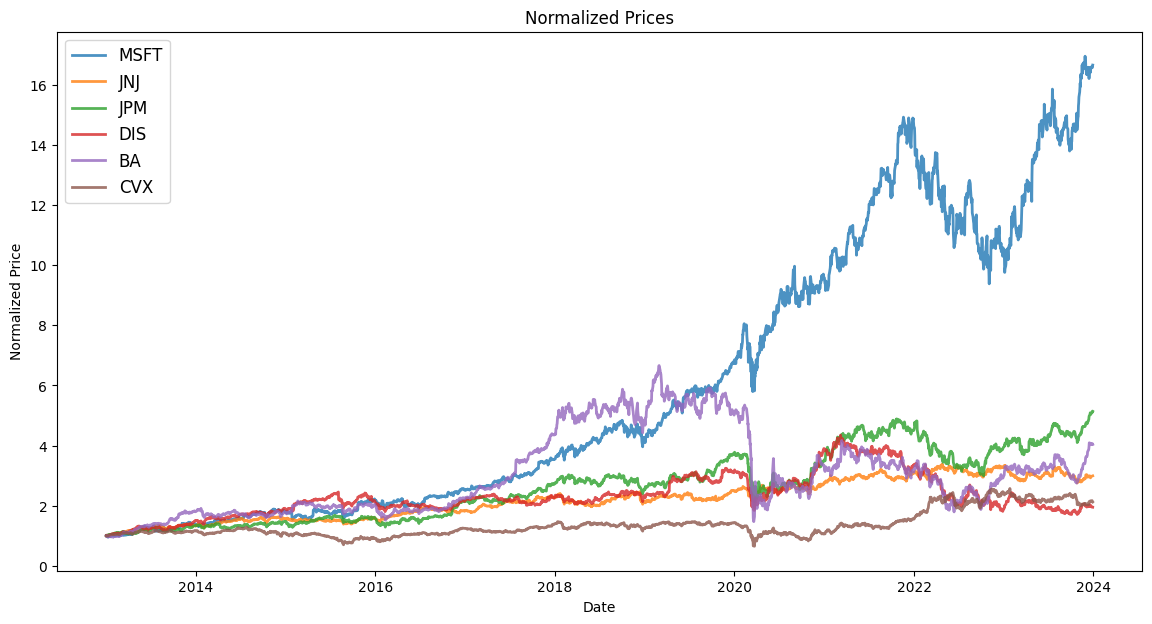

In [ ]:
# Compute the data matrix with log-returns
log_returns = np.log(prices).diff().iloc[1:]

# Number of stocks and number of days
N = log_returns.shape[1]  # Number of columns (stocks)
T = log_returns.shape[0]  # Number of rows (days)

# Normalize the prices
normalized_prices = prices / prices.iloc[0]

# Plot the normalized prices
plt.figure(figsize=(14, 7))
for c in normalized_prices.columns.values:
    plt.plot(normalized_prices.index, normalized_prices[c], lw=2, alpha=0.8, label=c)

plt.legend(loc='upper left', fontsize=12)
plt.title('Normalized Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.show()


In [ ]:
# Calculate the sample mean vector of the log returns
mu_daily = log_returns.mean()

# Calculate the sample covariance matrix of the log returns
Sigma_daily = log_returns.cov()

# Convert daily values to annual
mu = mu_daily * 252
Sigma = Sigma_daily * 252

# Display the results
print("Annual expected return vector (mu):\n", mu)
print("\nAnnual covariance matrix (Sigma):\n", Sigma)


Annual expected return vector (mu):
 MSFT    0.25618
JNJ     0.09984
JPM     0.14912
DIS     0.06082
BA      0.12707
CVX     0.06859
dtype: float64

Annual covariance matrix (Sigma):
          MSFT      JNJ      JPM      DIS       BA      CVX
MSFT  0.07216  0.01861  0.03175  0.03211  0.03919  0.02738
JNJ   0.01861  0.03100  0.01916  0.01538  0.02041  0.01852
JPM   0.03175  0.01916  0.06906  0.03839  0.05680  0.04511
DIS   0.03211  0.01538  0.03839  0.07003  0.05032  0.03268
BA    0.03919  0.02041  0.05680  0.05032  0.14485  0.05456
CVX   0.02738  0.01852  0.04511  0.03268  0.05456  0.08165


# MVO

In [ ]:
from scipy.optimize import minimize

# Define the target portfolio return
mu_0 = 0.2  # 20% target return

# Define the objective function for portfolio variance minimization
def objective_function_mvo(w, Sigma):
    return w.T @ Sigma @ w  # Portfolio variance

# Constraints include achieving the target return and ensuring full investment
constraints = [
    {'type': 'eq', 'fun': lambda w: w @ mu - mu_0},  # Target portfolio return constraint
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}   # Full investment constraint
]

# Initial guess with equal weighting across assets
w0 = np.ones(len(mu)) / len(mu)

# Bounds to prevent short selling by constraining weights between 0 and 1
bounds = tuple((0, 1) for _ in range(len(mu)))

# Perform the optimization using Sequential Least Squares Programming (SLSQP)
result = minimize(fun=objective_function_mvo, x0=w0, args=(Sigma,), method='SLSQP', constraints=constraints, bounds=bounds)

# Extract the optimal portfolio weights
w_star = result.x

# Display the calculated optimal weights
print("Optimal weights (w*):\n", w_star)

Optimal weights (w*):
 [6.09207e-01 2.90990e-01 9.98038e-02 7.15573e-18 2.12504e-17 0.00000e+00]


In [ ]:
# Calculate the portfolio return
portfolio_return = np.dot(w_star, mu)

print("Expected Portfolio Return:", portfolio_return)

Expected Portfolio Return: 0.20000000004529658


# Maximum return portfolio

In [ ]:
# Find the index of the asset with the highest expected return
i_star = np.argmax(mu)

# Allocate 100% to the asset with the highest expected return
w_mrp = np.zeros(len(mu))
w_mrp[i_star] = 1

print("Optimal weights for Maximum Return Portfolio (w_MRP):\n", w_mrp)
print("Corresponding stock ticker:\n", stock_symbols[i_star])

Optimal weights for Maximum Return Portfolio (w_MRP):
 [1. 0. 0. 0. 0. 0.]
Corresponding stock ticker:
 MSFT


# Global Minimum Variance Portfolio

In [ ]:
# Objective function for GMVP (portfolio variance)
def objective_function_gmvp(w, Sigma):
    return w.T @ Sigma @ w

# Constraint for the optimization (sum of weights equals 1)
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Sum of weights = 1
]

# Initial guess (equal weighting)
# Assuming mu is defined as your expected returns vector
w0 = np.ones(len(Sigma)) / len(Sigma)

# Optional: Bounds for the weights for no short-selling
bounds = tuple((0, 1) for _ in range(len(Sigma)))

# Perform the optimization
result = minimize(fun=objective_function_gmvp, x0=w0, args=(Sigma,), method='SLSQP', constraints=constraints, bounds=bounds)

# Extract the optimal weights
w_gmvp = result.x

# Display the optimal weights
print("Optimal weights for GMVP (w_GMVP):\n", w_gmvp)


Optimal weights for GMVP (w_GMVP):
 [9.29626e-02 6.69021e-01 3.69898e-02 1.32877e-01 5.20417e-18 6.81492e-02]


In [ ]:
# Calculate minimum portfolio variance
minimum_portfolio_variance = w_gmvp.T @ Sigma @ w_gmvp

# Display the minimum portfolio variance
print("Minimum Portfolio Variance:", minimum_portfolio_variance)

Minimum Portfolio Variance: 0.026449738111930413


# Maximum sharpe ratio portfolio

In [ ]:
Rf = 0.005  # Placeholder for the risk-free rate

# Objective function for MSRP (negative Sharpe Ratio)
def objective_function_msrp(w, mu, Sigma, Rf):
    Rp = np.dot(w, mu)  # Portfolio return
    sigma_p = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))  # Portfolio standard deviation
    sharpe_ratio = (Rp - Rf) / sigma_p
    return -sharpe_ratio  # Minimize negative Sharpe Ratio

# Constraint for the optimization (sum of weights equals 1)
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Sum of weights = 1
]

# Initial guess (equal weighting)
w0 = np.ones(len(mu)) / len(mu)

# Optional: Bounds for the weights for no short-selling
bounds = tuple((0, 1) for _ in range(len(mu)))

# Perform the optimization
result = minimize(fun=objective_function_msrp, x0=w0, args=(mu, Sigma, Rf), method='SLSQP', constraints=constraints, bounds=bounds)

# Extract the optimal weights
w_msrp = result.x

# Display the optimal weights
print("Optimal weights for MSRP (w_MSRP):\n", w_msrp)


Optimal weights for MSRP (w_MSRP):
 [6.86661e-01 2.19200e-01 9.41398e-02 4.08744e-17 0.00000e+00 1.99493e-17]


In [ ]:
# Dow Jones Industrial Average (DJIA) symbol
djia_symbol = '^DJI'

# Download DJIA data
djia_ticker = yf.Ticker(djia_symbol)
djia_hist_data = djia_ticker.history(start=start_date, end=end_date)

# Extracting close prices
djia_prices = djia_hist_data['Close']

# Handling missing values by interpolation
djia_prices.interpolate(method='linear', inplace=True)

# Display the head of the DJIA prices DataFrame
djia_prices.head()


Date
2013-01-02 00:00:00-05:00    13412.54980
2013-01-03 00:00:00-05:00    13391.36035
2013-01-04 00:00:00-05:00    13435.20996
2013-01-07 00:00:00-05:00    13384.29004
2013-01-08 00:00:00-05:00    13328.84961
Name: Close, dtype: float64

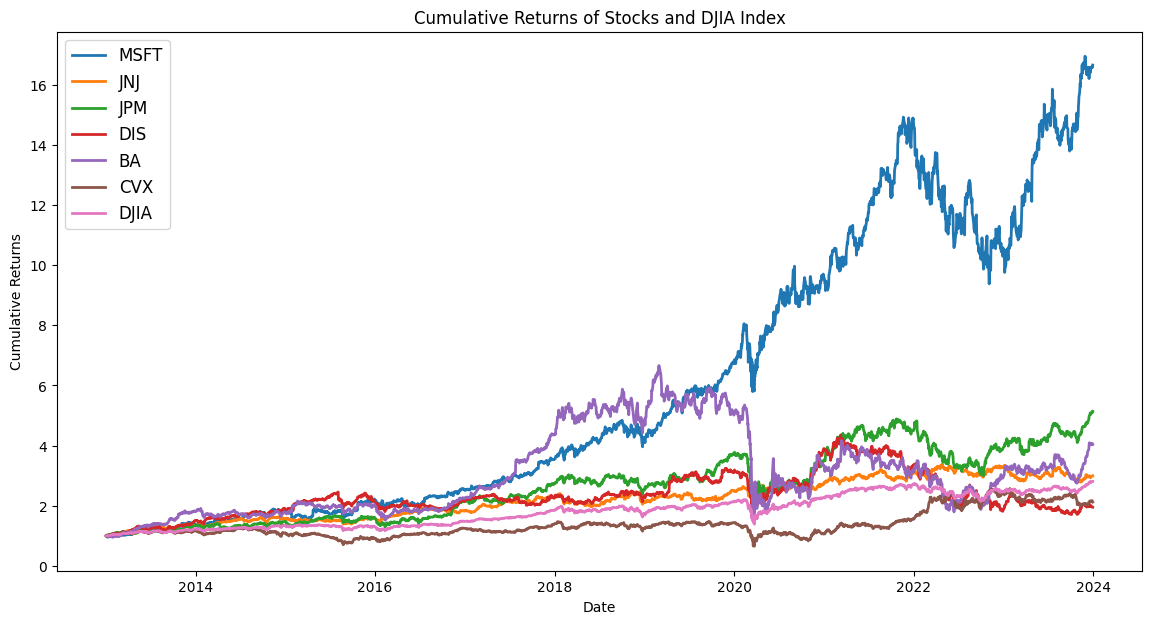

In [ ]:
import matplotlib.pyplot as plt

# Calculate daily returns for the stocks
stock_daily_returns = prices.pct_change()[1:]

# Calculate daily returns for the DJIA
djia_daily_returns = djia_prices.pct_change()[1:]

# Calculate cumulative returns for the stocks
stock_cumulative_returns = (1 + stock_daily_returns).cumprod()

# Calculate cumulative return for the DJIA
djia_cumulative_returns = (1 + djia_daily_returns).cumprod()

# Add DJIA cumulative returns to the stocks' cumulative returns DataFrame
stock_cumulative_returns['DJIA'] = djia_cumulative_returns

# Plotting cumulative returns
plt.figure(figsize=(14, 7))
for c in stock_cumulative_returns.columns.values:
    plt.plot(stock_cumulative_returns.index, stock_cumulative_returns[c], lw=2, label=c)

plt.title('Cumulative Returns of Stocks and DJIA Index')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left', fontsize=12)
plt.show()


In [ ]:
# Define your target return
target_return = 0.2

def tracking_error_optimization(weights):
    # Calculate portfolio returns as the dot product of weights and stock returns
    portfolio_returns = np.dot(stock_daily_returns, weights)
    # Calculate the tracking error as the mean squared difference between
    # portfolio returns and index returns
    tracking_error = np.mean((portfolio_returns - djia_daily_returns.values) ** 2)
    return tracking_error

# Constraints for the optimization
# Sum of weights equals 1 and portfolio return equals target_return
constraints = [
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
    {'type': 'eq', 'fun': lambda weights: np.dot(weights, mu) - target_return}
]

# Bounds to ensure weights are between 0 and 1 (no short selling)
bounds = tuple((0, 1) for asset in stock_symbols)

# Number of assets
n_assets = len(stock_symbols)

# Initial guess (equal weights)
initial_weights = np.ones(n_assets) / n_assets

# Perform the optimization
result = minimize(tracking_error_optimization, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimal weights
optimal_weights_idxtrack = result.x

# Display the optimal weights
print("Optimal weights for Index Tracking Portfolio:\n", optimal_weights)


Optimal weights for Index Tracking Portfolio:
 [0.54284 0.07634 0.22333 0.      0.15748 0.     ]


In [ ]:
portfolio_returns = np.dot(stock_daily_returns, optimal_weights)
# Calculate the tracking error as the mean squared difference between
# portfolio returns and index returns
tracking_error = np.mean((portfolio_returns - djia_daily_returns.values) ** 2)
tracking_error

4.531914054915266e-05

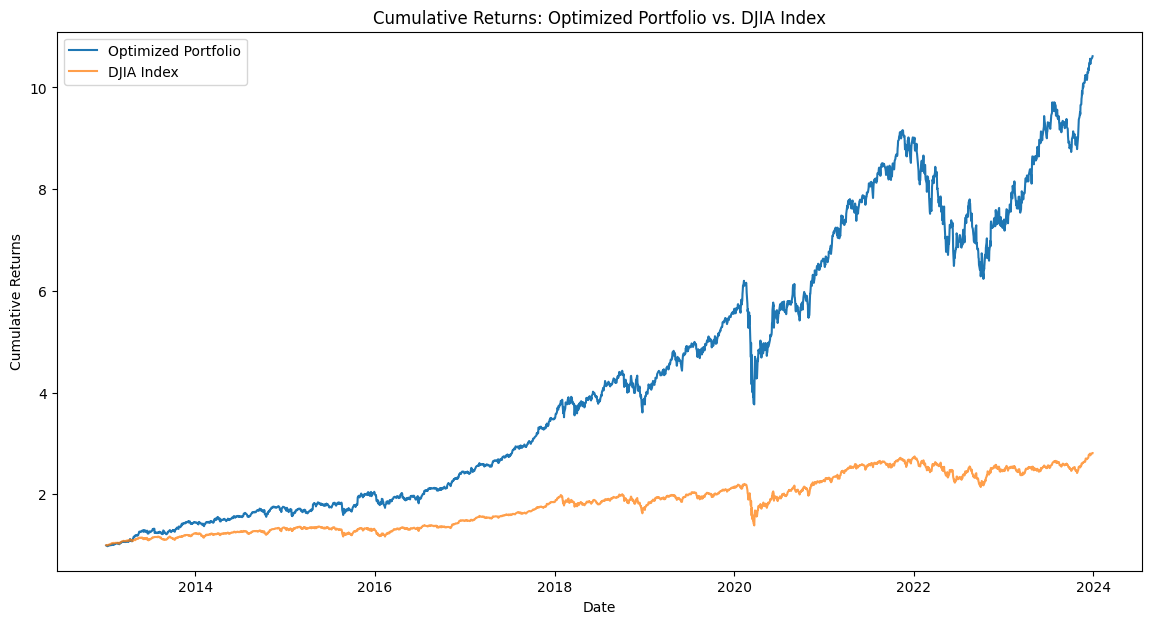

In [ ]:
# Calculate daily returns of the optimized portfolio
portfolio_daily_returns = np.dot(stock_daily_returns, optimal_weights)

# Assuming stock_daily_returns is a pandas DataFrame
portfolio_daily_returns_series = pd.Series(portfolio_daily_returns, index=stock_daily_returns.index)

# Calculate cumulative returns for the portfolio using the Series
portfolio_cumulative_returns = (1 + portfolio_daily_returns_series).cumprod()

# Plotting
plt.figure(figsize=(14, 7))

# Plot portfolio cumulative returns
plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, label='Optimized Portfolio')

# Assuming djia_cumulative_returns is a pandas Series
plt.plot(djia_cumulative_returns.index, djia_cumulative_returns, label='DJIA Index', alpha=0.75)

plt.title('Cumulative Returns: Optimized Portfolio vs. DJIA Index')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


In [ ]:
# Calculate excess returns of the portfolio over the index
excess_returns = portfolio_daily_returns_series - djia_daily_returns

# Calculate the standard deviation of the excess returns (daily tracking error)
tracking_error_daily = excess_returns.std()

# Annualize the tracking error
tracking_error_annualized = tracking_error_daily * np.sqrt(252)

# Convert to percentage
tracking_error_annualized_pct = tracking_error_annualized * 100

print("Daily Tracking Error: {:.2f}%".format(tracking_error_daily * 100))
print("Annualized Tracking Error: {:.2f}%".format(tracking_error_annualized_pct))


Daily Tracking Error: 0.67%
Annualized Tracking Error: 10.66%


# Mean-CVaR portfolio

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Set your parameters here
mu_0 = 0.001  # Target daily return
beta = 0.95  # Confidence level for CVaR
expected_returns = mu_daily

# Define the objective function for mean-CVaR optimization
def mean_cvar_objective(x):
    w = x[:-1]  # weights are all elements but the last
    alpha = x[-1]  # alpha is the last element
    portfolio_losses = -log_returns @ w - alpha
    u = np.maximum(portfolio_losses, 0)
    mean_cvar = alpha + np.mean(u) / (1 - beta)
    return mean_cvar

# Constraints
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x[:-1]) - 1},  # Weights sum to 1
    {'type': 'ineq', 'fun': lambda x: x[:-1] @ expected_returns - mu_0}  # Portfolio return >= mu_0
]

# Bounds for weights and alpha
bounds = tuple((0, 1) for _ in range(len(expected_returns))) + ((None, None),)  # No short selling, no bounds on alpha

# Initial guess (equal weights and an initial alpha, which is the CVaR estimate)
initial_guess = np.ones(len(expected_returns) + 1) / (len(expected_returns) + 1)

# Solve the optimization problem
result = minimize(mean_cvar_objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimal weights and alpha
optimal_weights_cvar = result.x[:-1]

# Display the results
print("Optimal weights for Mean-CVaR Portfolio:\n", optimal_weights)


Optimal weights for Mean-CVaR Portfolio:
 [9.62097e-01 2.43284e-03 3.54701e-02 3.34070e-18 1.35525e-19 2.05321e-18]
